In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

#Descargar el sets de perros y gatos

datos, metadatos = tfds.load('cats_vs_dogs', as_supervised=True, with_info=True)

In [ ]:
metadatos

In [ ]:
tfds.as_dataframe(datos['train'].take(5), metadatos)

In [ ]:
tfds.show_examples(datos['train'], metadatos)

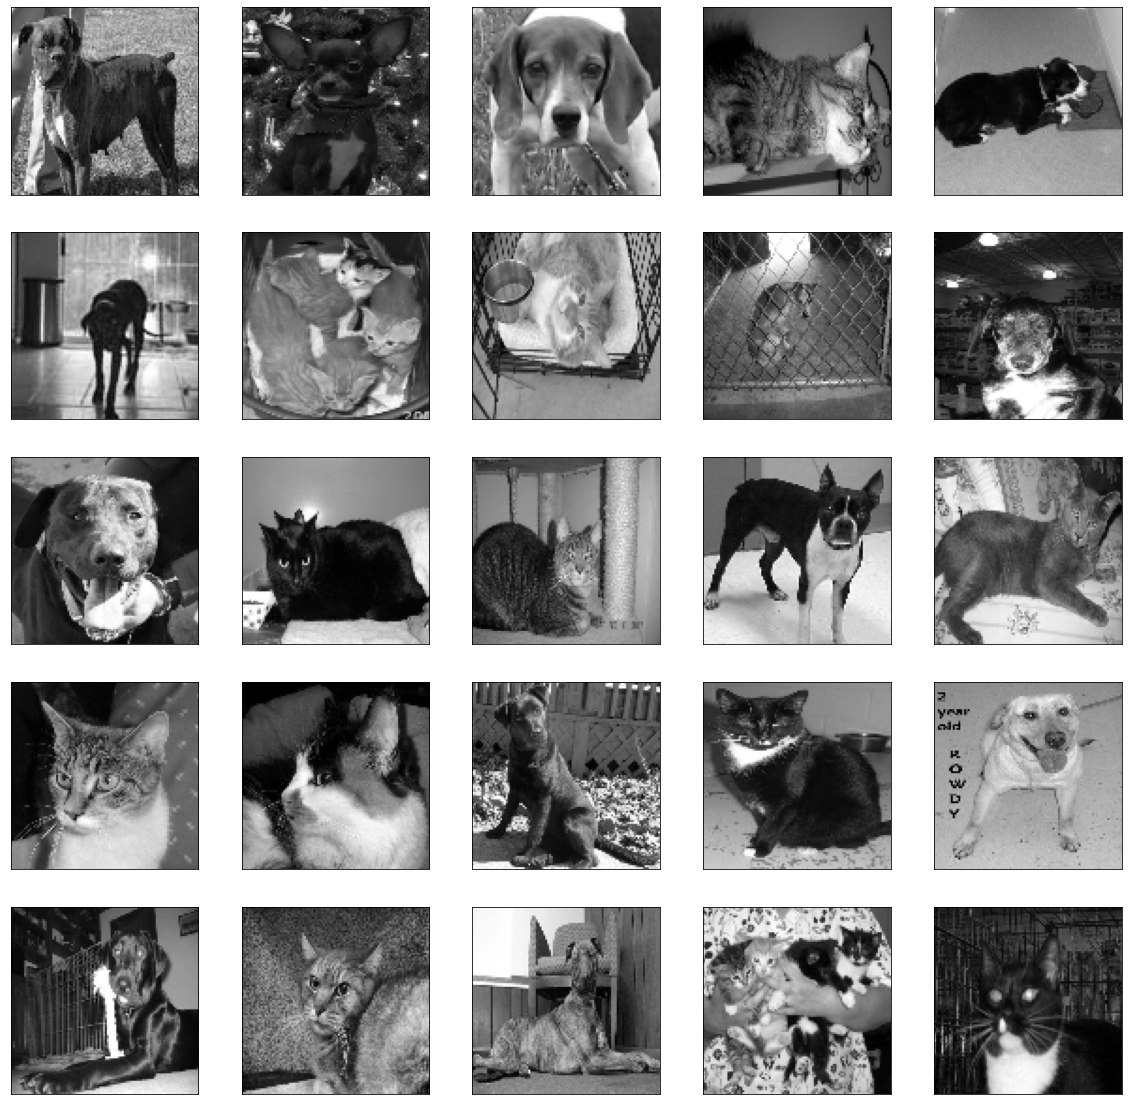

In [ ]:
#Manipular y visualizar el set
#Lo pasamos a TAMANO_IMG (100x100) y a blanco y negro (solo para visualizar)
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(20,20))

TAMANO_IMG=100

for i, (imagen, etiqueta) in enumerate(datos['train'].take(25)):
  imagen = cv2.resize(imagen.numpy(), (TAMANO_IMG, TAMANO_IMG))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(imagen, cmap='gray')

In [ ]:
datos_entrenamiento = []

In [ ]:
for i, (imagen, etiqueta) in enumerate(datos['train']): #Todos los datos
  imagen = cv2.resize(imagen.numpy(), (TAMANO_IMG, TAMANO_IMG))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  imagen = imagen.reshape(TAMANO_IMG, TAMANO_IMG, 1) #Cambiar tamano a 100,100,1
  datos_entrenamiento.append([imagen, etiqueta])

In [ ]:
datos_entrenamiento[0]

[array([[[242],
         [190],
         [105],
         ...,
         [189],
         [195],
         [143]],
 
        [[230],
         [130],
         [ 88],
         ...,
         [188],
         [179],
         [187]],
 
        [[170],
         [ 93],
         [ 84],
         ...,
         [131],
         [158],
         [168]],
 
        ...,
 
        [[112],
         [173],
         [164],
         ...,
         [141],
         [152],
         [119]],
 
        [[140],
         [151],
         [172],
         ...,
         [ 96],
         [150],
         [152]],
 
        [[ 92],
         [112],
         [168],
         ...,
         [ 44],
         [ 52],
         [ 47]]], dtype=uint8), <tf.Tensor: shape=(), dtype=int64, numpy=1>]

In [ ]:
len(datos_entrenamiento)

23262

In [ ]:
X = [] #imagenes de entrada (pixeles)
y = [] #etiquetas

for imagen, etiqueta in datos_entrenamiento:
  X.append(imagen)
  y.append(etiqueta)

In [ ]:
X

In [ ]:
import numpy as np

X = np.array(X).astype(float) / 255

In [ ]:
y

array([1, 1, 1, ..., 0, 1, 0])

In [ ]:
y = np.array(y)

In [ ]:
X.shape

(23262, 100, 100, 1)

In [ ]:
#Crear los modelos iniciales
#Usan sigmoid como salida (en lugar de softmax) para mostrar como podria funcionar con dicha funcion de activacion.
#Sigmoid regresa siempre datos entre 0 y 1. Realizamos el entrenamiento para al final considerar que si la respuesta se
#acerca a 0, es un gato, y si se acerca a 1, es un perro.

modeloDenso = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(100, 100, 1)),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloCNN = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloCNN2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(250, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
modeloDenso.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN2.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import TensorBoard 

In [ ]:
from gc import callbacks
tensorboardDenso = TensorBoard(log_dir='logs/denso')
modeloDenso.fit(X, y, batch_size=32, 
                validation_split=0.15,
                epochs=100,
                callbacks=[tensorboardDenso])

In [ ]:
%load_ext tensorboard

In [ ]:
#Ejecutar tensorboard e indicarle que lea la carpeta "logs"
%tensorboard --logdir logs

In [ ]:
tensorboardCNN = TensorBoard(log_dir='logs/cnn')
modeloCNN.fit(X, y, batch_size=32, 
                validation_split=0.15,
                epochs=100,
                callbacks=[tensorboardCNN])

In [ ]:
tensorboardCNN2 = TensorBoard(log_dir='logs/cnn2')
modeloCNN2.fit(X, y, batch_size=32,
                validation_split=0.15,
                epochs=100,
                callbacks=[tensorboardCNN2])

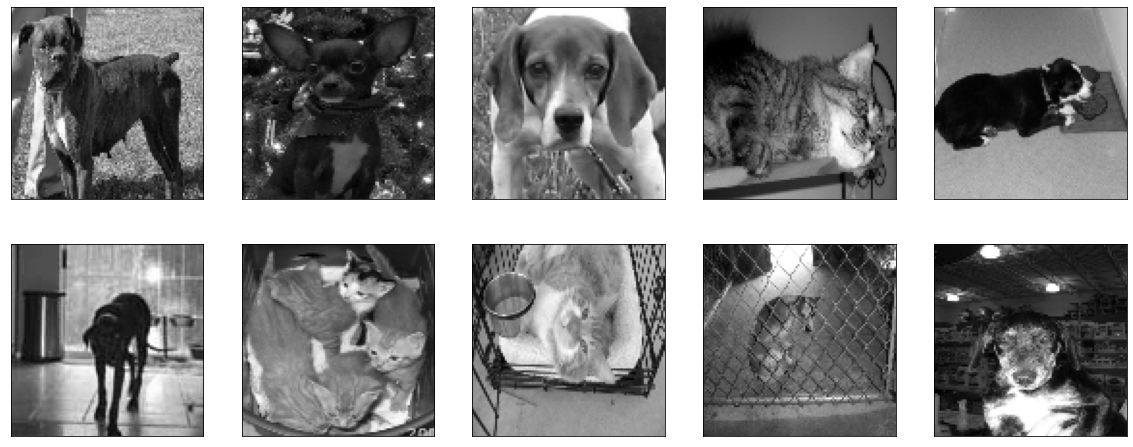

In [ ]:
#ver las imagenes de la variable X sin modificaciones por aumento de datos
plt.figure(figsize=(20, 8))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X[i].reshape(100, 100), cmap="gray")

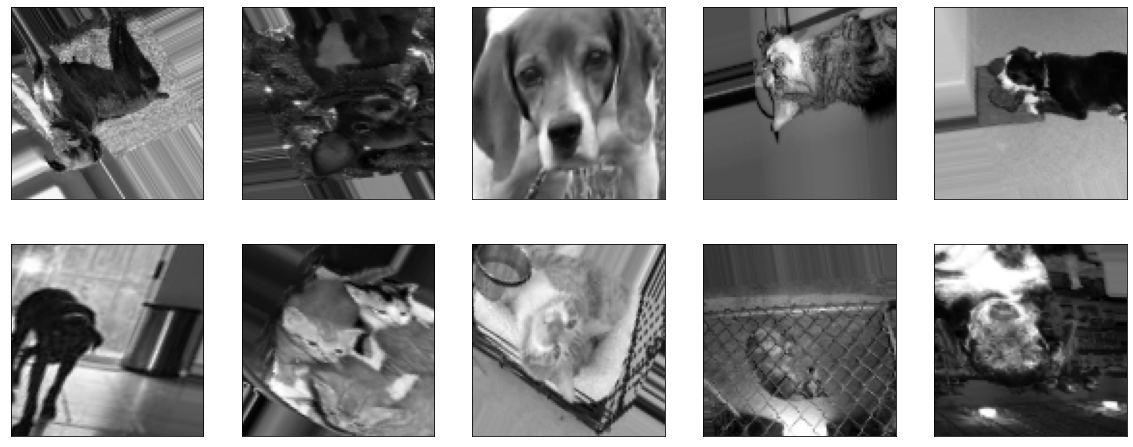

In [ ]:
#Realizar el aumento de datos con varias transformaciones. Al final, graficar 10 como ejemplo
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    zoom_range=[0.7, 1.4],
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X)

plt.figure(figsize=(20,8))

for imagen, etiqueta in datagen.flow(X, y, batch_size=10, shuffle=False):
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i].reshape(100, 100), cmap="gray")
  break

In [ ]:
modeloDenso_AD = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(100, 100, 1)),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloCNN_AD = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloCNN2_AD = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(250, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
modeloDenso_AD.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN_AD.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN2_AD.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [ ]:
#Separar los datos de entrenamiento y los datos de pruebas en variables diferentes

len(X) * .85 #19700
len(X) - 19700 #3562

X_entrenamiento = X[:19700]
X_validacion = X[19700:]

y_entrenamiento = y[:19700]
y_validacion = y[19700:]

In [ ]:
#Usar la funcion flow del generador para crear un iterador que podamos enviar como entrenamiento a la funcion FIT del modelo
data_gen_entrenamiento = datagen.flow(X_entrenamiento, y_entrenamiento, batch_size=32)

In [ ]:
tensorboardDenso_AD = TensorBoard(log_dir='logs/denso_AD')

modeloDenso_AD.fit(
    data_gen_entrenamiento,
    epochs=100, batch_size=32,
    validation_data=(X_validacion, y_validacion),
    steps_per_epoch=int(np.ceil(len(X_entrenamiento) / float(32))),
    validation_steps=int(np.ceil(len(X_validacion) / float(32))),
    callbacks=[tensorboardDenso_AD]
)

In [ ]:
tensorboardCNN_AD = TensorBoard(log_dir='logs-new/cnn_AD')

modeloCNN_AD.fit(
    data_gen_entrenamiento,
    epochs=150, batch_size=32,
    validation_data=(X_validacion, y_validacion),
    steps_per_epoch=int(np.ceil(len(X_entrenamiento) / float(32))),
    validation_steps=int(np.ceil(len(X_validacion) / float(32))),
    callbacks=[tensorboardCNN_AD]
)

Epoch 1/100
616/616 [==============================] - 346s 562ms/step - loss: 0.6600 - accuracy: 0.6057 - val_loss: 0.6440 - val_accuracy: 0.6235
Epoch 2/100
616/616 [==============================] - 342s 555ms/step - loss: 0.6446 - accuracy: 0.6306 - val_loss: 0.6266 - val_accuracy: 0.6334
Epoch 3/100
616/616 [==============================] - 341s 554ms/step - loss: 0.6252 - accuracy: 0.6519 - val_loss: 0.5668 - val_accuracy: 0.7106
Epoch 4/100
616/616 [==============================] - 339s 551ms/step - loss: 0.6026 - accuracy: 0.6740 - val_loss: 0.5387 - val_accuracy: 0.7310
Epoch 5/100
616/616 [==============================] - 338s 548ms/step - loss: 0.5945 - accuracy: 0.6824 - val_loss: 0.5538 - val_accuracy: 0.7167
Epoch 6/100
616/616 [==============================] - 331s 537ms/step - loss: 0.5827 - accuracy: 0.6917 - val_loss: 0.5154 - val_accuracy: 0.7437
Epoch 7/100
616/616 [==============================] - 337s 547ms/step - loss: 0.5707 - accuracy: 0.7023 - val_loss: 0

In [ ]:
tensorboardCNN2_AD = TensorBoard(log_dir='logs/cnn2_AD')

modeloCNN2_AD.fit(
    data_gen_entrenamiento,
    epochs=100, batch_size=32,
    validation_data=(X_validacion, y_validacion),
    steps_per_epoch=int(np.ceil(len(X_entrenamiento) / float(32))),
    validation_steps=int(np.ceil(len(X_validacion) / float(32))),
    callbacks=[tensorboardCNN2_AD]
)

In [ ]:
modeloCNN_AD.save('perros-gatos-cnn-ad.h5')

In [ ]:
!pip install tensorflowjs

In [ ]:
!mkdir carpeta_salida

In [ ]:
!tensorflowjs_converter --input_format keras perros-gatos-cnn-ad.h5 carpeta_salida